In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys
import random
import seaborn as sns
from matplotlib.font_manager import FontProperties
font1 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=14)
font2 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=12)
font3 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=10)
font4 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=7)
sns.set_style('whitegrid')
sns.set_palette("muted")
random.seed(20241117)
np.random.seed(20241117)
torch.manual_seed(3407) # Torch.manual_seed(3407) is all you need. Paper: http://arxiv.org/abs/2109.08203
# 修改工作路径，使本.ipynb文件能够像在本文件夹根目录下一样导入其他模块
# Modify the working path so that this.ipynb file can import other modules like in the root directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(current_dir, '..'))

In [2]:
df_whole=pd.read_excel("E:\\科创优才\\实验数据\\天然气锅炉数据1.xlsx", sheet_name="稳定运行数据段")
units=df_whole.iloc[0].tolist()
df=df_whole.iloc[2:].reset_index(drop=True)
df.columns=new_column_names=[ # 重命名列名
    '开始时间',
    '主蒸汽流量计算值',
    '烟气含氧量（CEMS）',
    '颗粒浓度',
    '二氧化硫',
    'NO浓度',
    'NO2浓度',
    'NOX标干浓度',
    'NOX浓度',
    '烟气湿度（CEMS）',
    '烟气压力（CEMS）',
    '烟气温度（CEMS）',
    '一氧化碳',
    '锅炉天然气进气流量',
    '锅炉天然气进气温度',
    '锅炉天然气进气压力',
    '鼓风机出口温度',
    '鼓风机出口压力',
    '鼓风机变频器输出反馈',
    '鼓风机变频器电流反馈',
    '再循环烟气调节阀反馈',
    '冷凝器出口烟气调节阀反馈',
    '炉膛出口烟气温度（B分度）',
    '炉膛出口烟气压力',
    'SWY大气压',
    'SWY天气温度',
    'SWY空气湿度',
    'SWY湿球温度',
    '主蒸汽温度(蒸汽集箱出口温度）',
    '主蒸汽压力(蒸汽集箱出口压力）',
    '分汽缸温度',
    '分汽缸压力',
    '分汽缸出口至DN400蒸汽温度',
    '过热器集箱出口蒸汽温度',
    '天然气累计流量',
    '冷凝器烟气流量（累计值）',
    '冷凝器出口烟气流量',
    '冷凝器出口烟气温度'
]
var_names=['主蒸汽流量计算值', # 选取相关变量
    '烟气含氧量（CEMS）',
    'NO浓度',
    'NO2浓度',
    'NOX浓度',
    '烟气湿度（CEMS）',
    '烟气压力（CEMS）',
    '烟气温度（CEMS）',
    '一氧化碳',
    '锅炉天然气进气流量',
    '锅炉天然气进气温度',
    '锅炉天然气进气压力',
    '鼓风机出口温度',
    '鼓风机出口压力',
    '鼓风机变频器输出反馈',
    '鼓风机变频器电流反馈',
    '冷凝器出口烟气调节阀反馈',
    '炉膛出口烟气温度（B分度）',
    '炉膛出口烟气压力',
    'SWY大气压',
    'SWY天气温度',
    'SWY空气湿度',
    'SWY湿球温度',
    '主蒸汽温度(蒸汽集箱出口温度）',
    '主蒸汽压力(蒸汽集箱出口压力）',
    '分汽缸温度',
    '分汽缸压力',
    '分汽缸出口至DN400蒸汽温度',
    '过热器集箱出口蒸汽温度',
    '冷凝器出口烟气流量',
    '冷凝器出口烟气温度'
]
data_np=df[var_names].to_numpy(dtype=float)
print(data_np.shape)

(1124, 31)


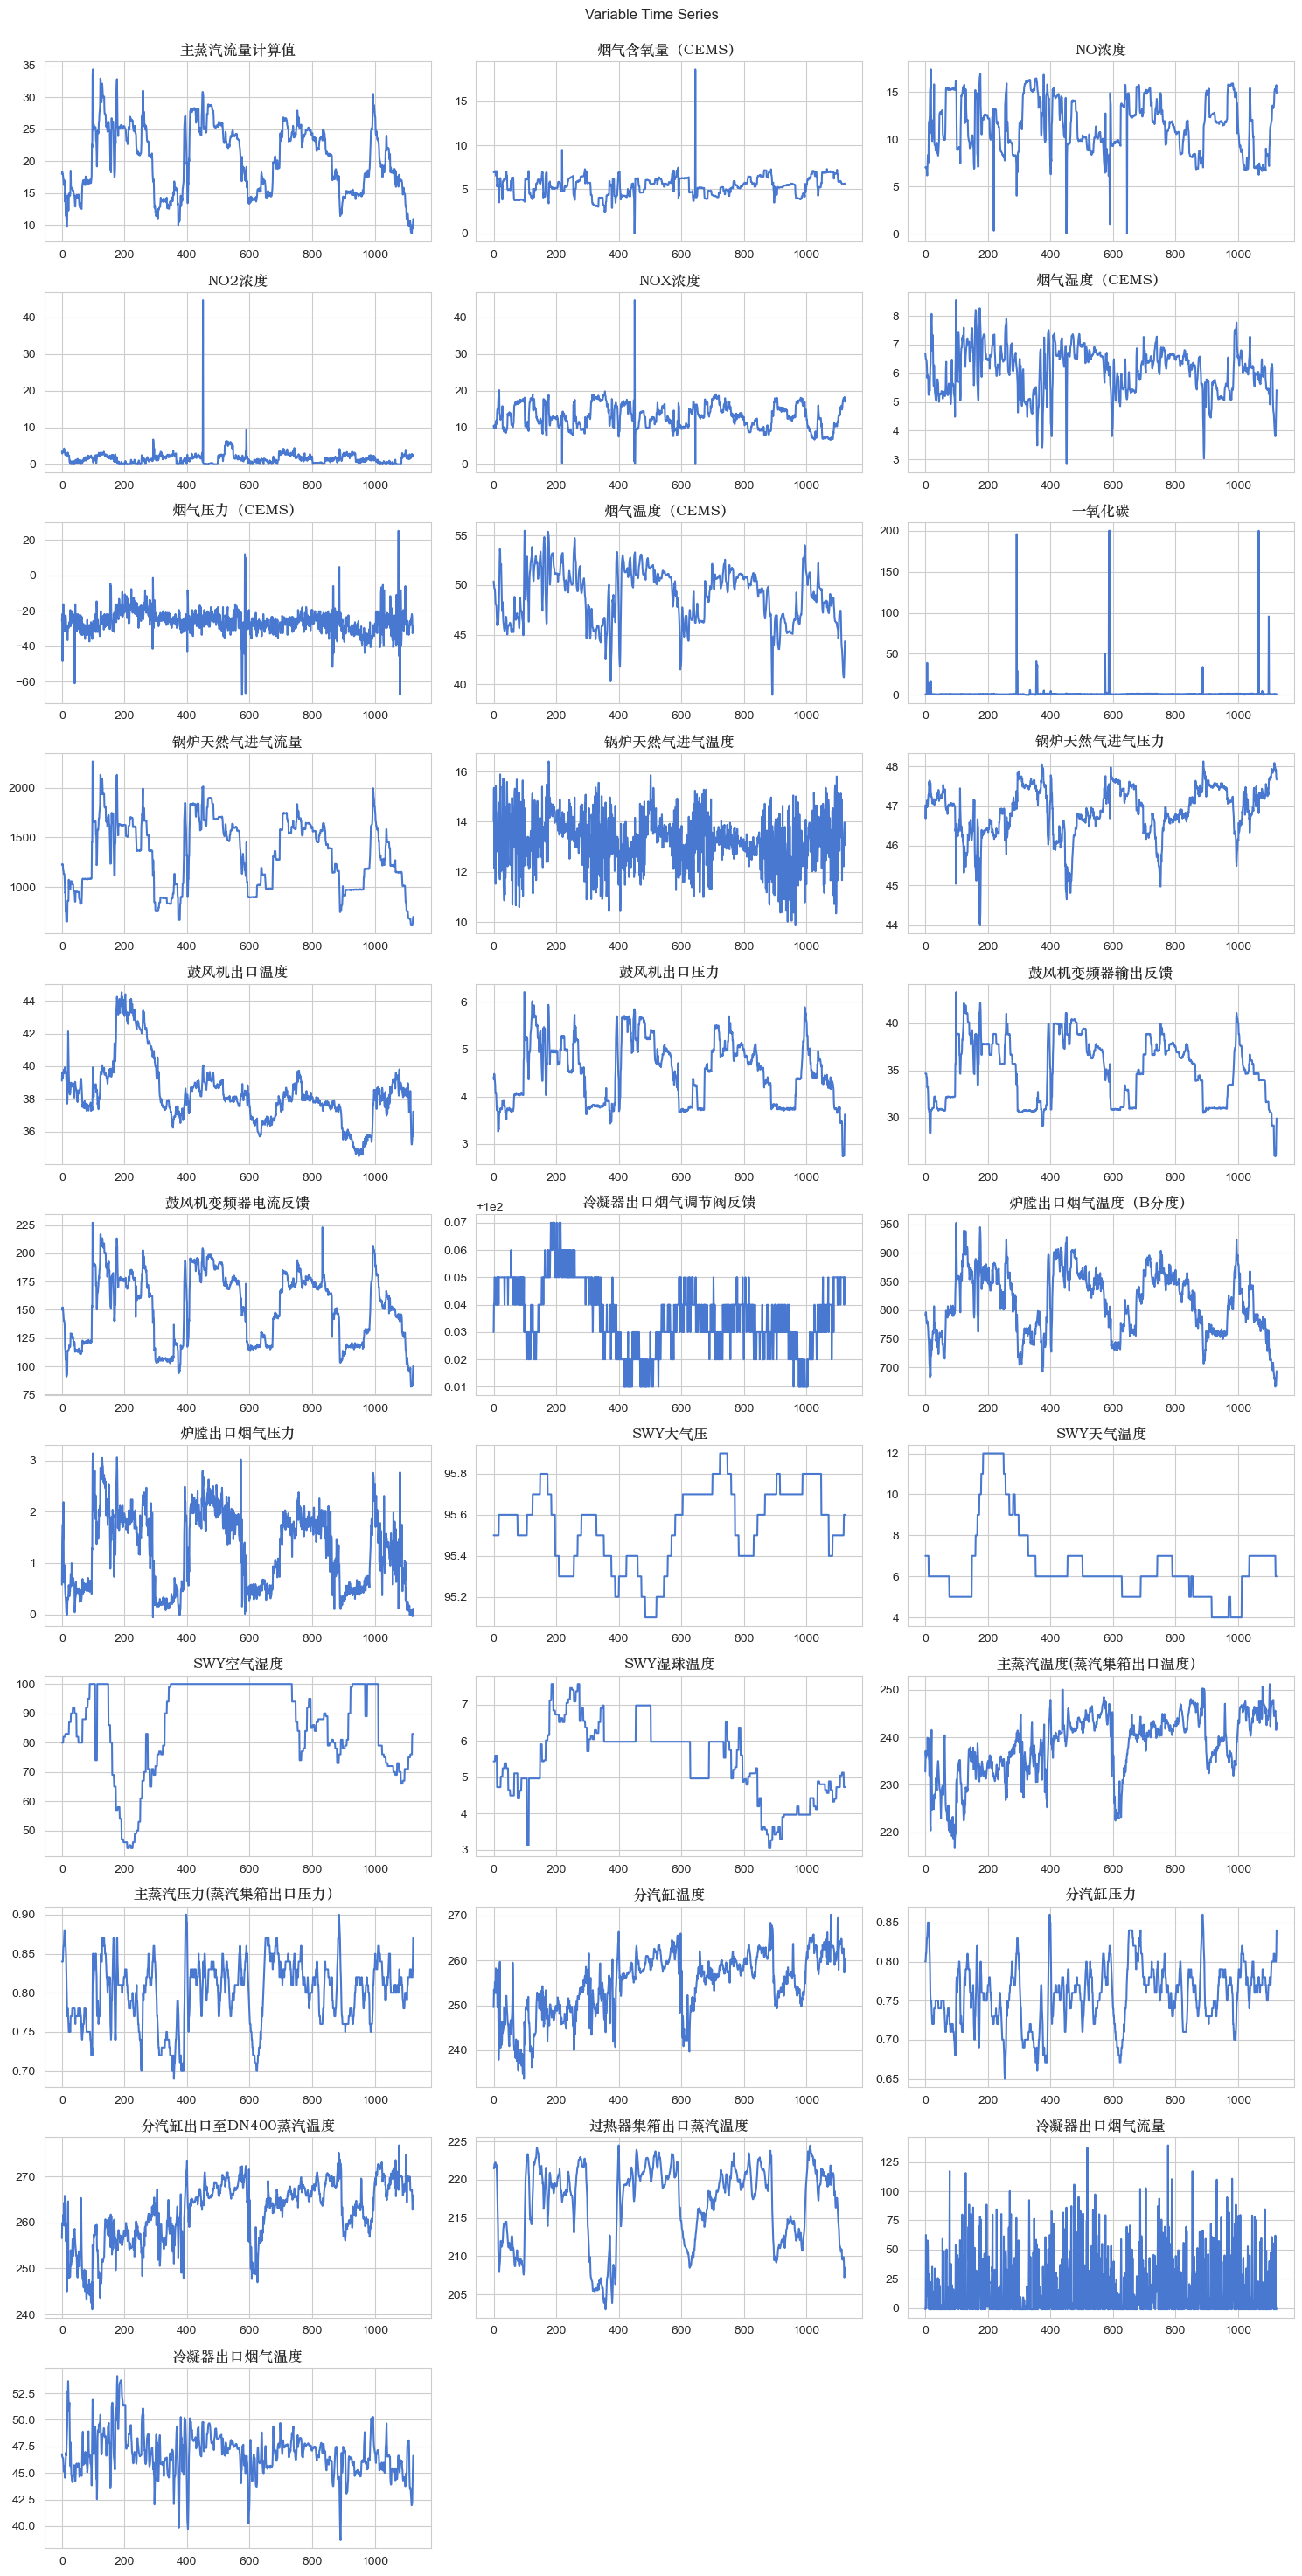

In [3]:
plt.figure(figsize=(15,30))
plt.suptitle('Variable Time Series')
nrows=len(var_names)//3+1
ncolumns=3
length=df.shape[0]
for i, var_name in enumerate(var_names):
    plt.subplot(nrows, ncolumns, i + 1)
    plt.plot(np.arange(length), df[var_name])
    plt.title(var_name, fontproperties=font2)
plt.tight_layout()
plt.subplots_adjust(top=0.96)
plt.show()

In [4]:
def time_series_split(data, input_len, output_len,output_index=None,mode="single"):
    r'''
    Split a time series data into input and output sequences.

    :param data: a numpy array or a list of numpy arrays. If a list, the numpy arrays must have the same number of columns.
    :param input_len: the length of each input sequence.
    :param output_len: the length of each output sequence.
    :param output_index: the index of the output variables. If None, all variables are used as output variables.

    if mode=="single":
        np.ndarray -> np.ndarray, np.ndarray
        :return: X, Y. X and Y are numpy arrays.
        
    elif mode=="multiple":
        [np.ndarray, ...] -> np.ndarray, np.ndarray, [np.ndarray, ...], [np.ndarray, ...]
        :return: X, Y, X_grouped, Y_grouped. X and Y are numpy arrays, and X_grouped and Y_grouped are lists of numpy arrays.
    '''

    if mode=="single": # If only a single 2-d numpy array needs partitioning
        assert type(data)==np.ndarray and data.ndim==2, "data must be a 2-d numpy array"
        n_steps,n_vars = data.shape
        output_index=range(n_vars) if output_index is None else output_index
        X, Y = [], []
        for i in range(0,n_steps-input_len-output_len+1,output_len):
            X.append(data[i:i+input_len,:])
            Y.append(data[i+input_len:i+input_len+output_len,output_index])
        X, Y = np.array(X).astype("float32"), np.array(Y).astype("float32")
        return X, Y # (N, input_len, n_vars), (N, output_len, len(output_index))

    elif mode=="multiple": # If multiple 2-d numpy arrays (packed in a list) need partitioning
        assert type(data)==list and all([isinstance(item, np.ndarray) for item in data]) and all([item.ndim==2 for item in data]), "data must be a list of 2D numpy arrays"
        assert all([item.shape[1]==data[0].shape[1] for item in data]), "All numpy arrays in data must have the same number of columns (features)"
        X_grouped=[]
        Y_grouped=[]
        for data_i in data: # data_i: numpy array. Shape: (mat_data_len, len(var_names))
            data_i_length=data_i.shape[0] # The (time series) length of the current mat data
            X_i=[]
            Y_i=[]
            for i in range(0, data_i_length-input_len-output_len, output_len):
                X_i.append(data_i[i:i+input_len,:])
                Y_i.append(data_i[i+input_len:i+input_len+output_len,:]) # When label_len==0, X_i and Y_i don't intersect, and pred_len==output_len
            X_grouped.append(X_i)
            Y_grouped.append(Y_i)
        X=[]
        Y=[]
        for X_i in X_grouped:
            for X_ij in X_i:
                X.append(X_ij)
        for Y_i in Y_grouped:
            for Y_ij in Y_i:
                Y.append(Y_ij)
        X=np.array(X).astype("float32") # X shape: (N, input_len, n_vars)
        Y=np.array(Y).astype("float32") # Y shape: (N, output_len, len(output_index))
        return X,Y,X_grouped,Y_grouped
    else:
        raise ValueError("Invalid mode argument. Must be 'single' or 'multiple'.")






In [5]:
def time_series_standardization(data, mode="single"):
    """
    Standardize time series data by removing the mean and scaling to unit variance.

    :return: transformed_data, 2-d numpy array or list of 2-d numpy arrays
    :return: var_mean, 1-d numpy array
    :return: var_std_dev, 1-d numpy array
    """
    if mode=="single": # If only a single 2-d numpy array needs standardization
        assert type(data)==np.ndarray and data.ndim==2, "data must be a 2-d numpy array"
        n_vars = data.shape[1]
        var_mean = np.mean(data,axis=0)
        var_std_dev = np.std(data,axis=0)
        transformed_data = (data-var_mean)/var_std_dev
        return transformed_data, var_mean, var_std_dev

    elif mode=="multiple": # If multiple 2-d numpy arrays (packed in a list) need standardization
        assert type(data)==list and all([isinstance(item, np.ndarray) for item in data]) and all([item.ndim==2 for item in data]), "data must be a list of 2D numpy arrays"
        assert all([item.shape[1]==data[0].shape[1] for item in data]), "All numpy arrays in data must have the same number of columns (features)"
        count=np.sum([d.shape[0] for d in data]) # total timestep count
        var_mean = np.sum([np.sum(d, axis=0) for d in data], axis=0)/count
        var_std_dev=np.sqrt(np.sum([np.sum((d - var_mean) ** 2, axis=0) for d in data], axis=0)/count)
        transformed_data = [(d-var_mean)/var_std_dev for d in data]
        return transformed_data, var_mean, var_std_dev


In [6]:
ll=[np.random.rand(180,13),np.random.rand(460,13),np.random.rand(1180,13),]
display(time_series_standardization(ll, mode="multiple")[2].shape)
display(time_series_split(ll, input_len=10, output_len=1,mode="multiple")[0].shape)

(13,)

(1787, 10, 13)

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR


from sklearn.metrics import mean_squared_error, r2_score

data_np, _ , _ =time_series_standardization(data=data_np)
X,Y=time_series_split(data=data_np,input_len=1, output_len=1)
X,Y=X.squeeze(1),Y.squeeze(1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# 创建线性回归模型
#model = LinearRegression()
#model = Ridge(alpha=0.5)
#model = Lasso(alpha=0.5)
#model = ElasticNet(alpha=0.5, l1_ratio=0.5)
model = LinearSVR()

# 训练模型
model.fit(X_train, Y_train[:,0])
# 进行预测
Y_pred = model.predict(X)






d:\Anaconda3\envs\env_py312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(100, 4)
(100,)


In [12]:
Y_train[:,0].shape

(898,)

In [19]:
# 评估模型
mse = mean_squared_error(Y[:,0], Y_pred)
r2 = r2_score(Y[:,0], Y_pred)

print(f'均方误差 (MSE): {mse}')
print(f'决定系数 (R^2): {r2}')

均方误差 (MSE): 0.026889489373195196
决定系数 (R^2): 0.9731301400047354


In [85]:
X.shape

(1123, 31)

In [84]:
data_np.shape

(1124, 31)

In [86]:
X_train.shape

(898, 31)

In [89]:
Y_pred.shape

(1123, 31)

In [18]:
np.mean((Y_pred-Y[:,0])**2)

0.026889489373195196

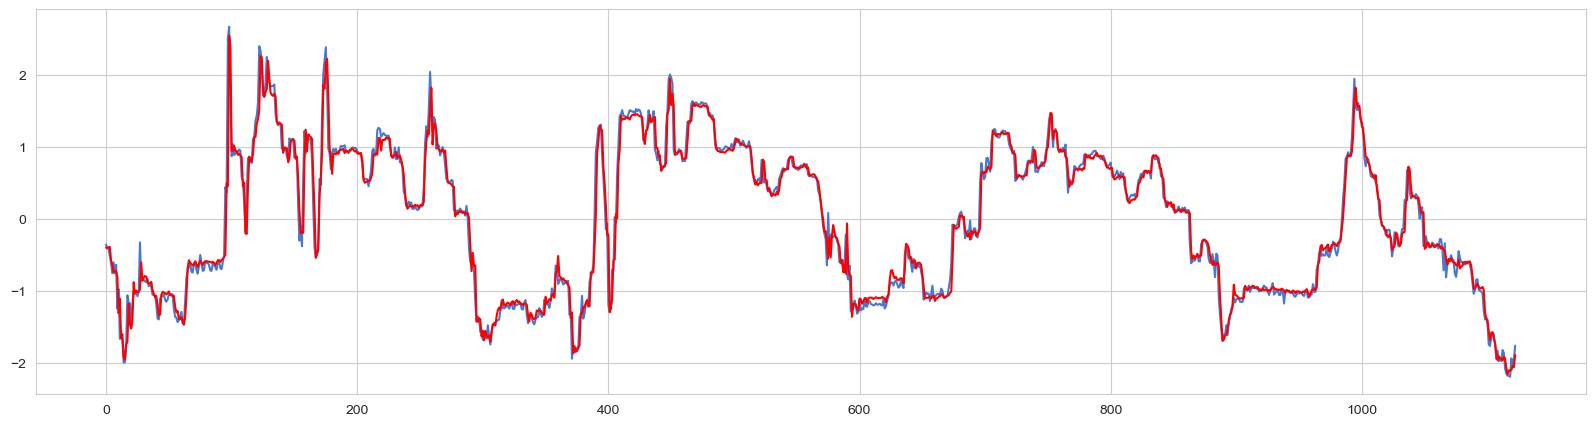

In [17]:
plt.figure(figsize=(20,5))
plt.plot(Y[:,0])
plt.plot(Y_pred, c='r')
plt.show()

In [51]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [52]:
ts=pd.Series(data_np[:,0])
result = adfuller(ts)

# 输出检验结果
adf_statistic = result[0]
p_value = result[1]
used_lag = result[2]
n_obs = result[3]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print(f'Critical Values:')
for key, value in critical_values.items():
    print(f'{key}: {value}')

# 检验平稳性
if p_value < 0.05:
    print("拒绝原假设：时间序列是平稳的")
else:
    print("不拒绝原假设：时间序列是非平稳的")

ADF Statistic: -2.9054937151751403
p-value: 0.04471287270730514
Critical Values:
1%: -3.436265626824956
5%: -2.864152052269338
10%: -2.568160735738769
拒绝原假设：时间序列是平稳的


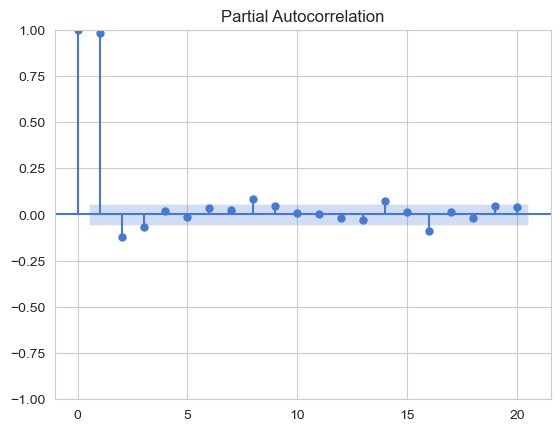

In [53]:
plot_pacf(ts, lags=20, ax=plt.gca())

In [54]:
from statsmodels.tsa.api import VAR
p=5
model = VAR(X)
results = model.fit(p) # 使用阶数为3的VAR模型

# 进行预测
forecast = results.forecast(X_train[0:p], steps=1)

In [55]:
X_train

array([[-1.7611828 ,  0.42819792, -0.03917916, ..., -0.56660366,
        -0.7349088 , -0.5947528 ],
       [-0.5764264 ,  1.5831113 , -1.6075761 , ...,  0.73743886,
        -0.734507  , -1.5708078 ],
       [ 0.9743216 , -0.13582952,  0.27519885, ...,  0.4660092 ,
         0.9954952 ,  3.2339993 ],
       ...,
       [ 0.34421232, -0.15373516,  0.1319822 , ...,  0.48567802,
        -0.5577302 , -0.13691251],
       [-0.99335504,  1.251857  , -1.132516  , ...,  0.01952707,
        -0.7349088 , -1.1431549 ],
       [ 0.16121651,  0.92060286, -1.094092  , ...,  0.89675623,
        -0.46894005, -0.37337947]], dtype=float32)

In [56]:
forecast.shape

(1, 31)

In [57]:
X_train[0:5].shape

(5, 31)

In [58]:
X.shape

(1122, 31)

In [59]:
forecast.shape

(1, 31)

In [60]:
import numpy as np

# 生成示例数据
np.random.seed(0)
n_obs = 100  # 观察值的数量
n_vars = 5   # 变量的数量

# 创建一个含5个变量的随机时间序列数据
data = np.random.randn(n_obs, n_vars)

# 确定滞后阶数
p = 3

# 准备数据矩阵
X = np.empty((n_obs - p, p * n_vars))
Y = np.empty((n_obs - p, n_vars))

for i in range(n_obs - p):
    X[i] = data[i:i + p].flatten()  # 将前p个观测展开为行
    Y[i] = data[i + p]  # 当前观测的值

# 计算参数估计
# 使用公式 beta = (X'X)^(-1)X'Y
X_transpose = X.T
beta = np.linalg.inv(X_transpose @ X) @ (X_transpose @ Y)

# 打印自回归系数
print("自回归系数：")
print(beta)

# 进行预测（假设我们要预测接下来的5个观测值）
last_obs = data[-p:]  # 获取最后p个观测值
forecasts = []

for _ in range(5):
    # 预测下一个值
    next_forecast = beta @ last_obs.flatten()  # 计算预测值
    forecasts.append(next_forecast)
    
    # 更新最后的观测
    last_obs = np.roll(last_obs, -1, axis=0)  # 滚动最后的观测
    last_obs[-1] = next_forecast  # 替换最后一行

# 打印预测结果
print("\n未来5个预测值：")
for i, forecast in enumerate(forecasts, start=1):
    print(f"预测值 {i}: {forecast}")


自回归系数：
[[ 0.1528787  -0.06923238 -0.01483729  0.04959771  0.11804583]
 [ 0.15287431 -0.00585843 -0.1835282  -0.06690959  0.0432368 ]
 [ 0.10229704  0.16176545 -0.15372067  0.04385396 -0.01853643]
 [-0.03093645  0.15951923 -0.08741575  0.09873365 -0.07295678]
 [-0.03027752 -0.00627293  0.18544373 -0.03678317 -0.03457092]
 [ 0.06209159 -0.11856208  0.05643142  0.09936419  0.06861663]
 [-0.18608558 -0.02536522  0.08596867 -0.05535202  0.00806937]
 [ 0.00595329  0.01668116 -0.01307746 -0.07418183  0.09127848]
 [-0.10219543  0.11422261  0.10297784  0.1164872  -0.10197034]
 [ 0.02132367  0.30802411 -0.01957563  0.06187053  0.13297435]
 [-0.0278066  -0.01030283 -0.11971673  0.05830806 -0.0195562 ]
 [-0.07608888 -0.01179783 -0.07891382  0.42341781  0.02765303]
 [ 0.09591183 -0.07989148  0.06825513  0.07220923  0.00885346]
 [ 0.31232453 -0.04193552 -0.04165817  0.01552258 -0.13546605]
 [-0.04175356  0.08496619 -0.10959524 -0.00228559 -0.09904828]]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 15 is different from 5)